<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

In [16]:
df = pd.read_parquet('data/lander_all_data.parquet')
#  Extract an interesting subset of the data
# We only want the "trained" data, and we only want the x, y, vx, vy columns
# Other options includ "random" "good" "better"
data = df.loc[('trained', slice(None)), (slice(None),('x','y', 'vx', 'vy'))]

In [17]:
data

idx                      0         1         2         3         4    \
parameter                  x         x         x         x         x   
run_idx experiment                                                     
trained 0          -0.001627 -0.003505 -0.005382 -0.007259 -0.009137   
        1          -0.005120 -0.005355 -0.005590 -0.005825 -0.006060   
        2          -0.000479 -0.003802 -0.007125 -0.010448 -0.013771   
        3          -0.005287 -0.007566 -0.009845 -0.012124 -0.014403   
        4          -0.005204 -0.011229 -0.017253 -0.023278 -0.029302   
...                      ...       ...       ...       ...       ...   
        1019        0.006561  0.022115  0.037669  0.053223  0.068777   
        1020        0.004974  0.015659  0.026343  0.037028  0.047713   
        1021       -0.007446 -0.000433  0.006580  0.013593  0.020606   
        1022        0.006551  0.020013  0.033475  0.046937  0.060399   
        1023       -0.004069  0.004273  0.012615  0.020956  0.029298   

idx                      5         6         7         8         9    ...  \
parameter                  x         x         x         x         x  ...   
run_idx experiment                                                    ...   
trained 0          -0.011014 -0.012892 -0.014769 -0.016647 -0.018524  ...   
        1          -0.006295 -0.006530 -0.006764 -0.006999 -0.007234  ...   
        2          -0.017094 -0.020417 -0.023740 -0.027063 -0.030386  ...   
        3          -0.016683 -0.018962 -0.021241 -0.023520 -0.025799  ...   
        4          -0.035326 -0.041172 -0.047017 -0.052863 -0.058708  ...   
...                      ...       ...       ...       ...       ...  ...   
        1019        0.084331  0.099885  0.115439  0.130994  0.146548  ...   
        1020        0.058397  0.069082  0.079766  0.090451  0.101136  ...   
        1021        0.027618  0.034631  0.041644  0.048657  0.055670  ...   
        1022        0.073861  0.087323  0.100785  0.114247  0.127709  ...   
        1023        0.037640  0.045982  0.054324  0.062665  0.071007  ...   

idx                      91        92        93        94        95   \
parameter                 vy        vy        vy        vy        vy   
run_idx experiment                                                     
trained 0          -0.636416 -0.638210 -0.640003 -0.641797 -0.643590   
        1          -0.906278 -0.918768 -0.931257 -0.943747 -0.956237   
        2          -0.279203 -0.271335 -0.263467 -0.255599 -0.247730   
        3          -0.860781 -0.868364 -0.875947 -0.883530 -0.891113   
        4          -0.911074 -0.910321 -0.909567 -0.908814 -0.908060   
...                      ...       ...       ...       ...       ...   
        1019       -0.173952 -0.171624 -0.169296 -0.166968 -0.164639   
        1020       -0.474361 -0.483990 -0.493620 -0.503249 -0.512879   
        1021       -0.539696 -0.547828 -0.555960 -0.564091 -0.572223   
        1022       -0.311161 -0.285919 -0.260677 -0.235435 -0.210193   
        1023       -0.328814 -0.331235 -0.333656 -0.336078 -0.338499   

idx                      96        97        98        99        100  
parameter                 vy        vy        vy        vy        vy  
run_idx experiment                                                    
trained 0          -0.645383 -0.647177 -0.648970 -0.650764 -0.652557  
        1          -0.968727 -0.981217 -0.993707 -1.006196 -1.018686  
        2          -0.239862 -0.231994 -0.224125 -0.216257 -0.208389  
        3          -0.898695 -0.906278 -0.913861 -0.921444 -0.929027  
        4          -0.921853 -0.935646 -0.949438 -0.963231 -0.977024  
...                      ...       ...       ...       ...       ...  
        1019       -0.162311 -0.159983 -0.157655 -0.155327 -0.152999  
        1020       -0.522508 -0.532138 -0.541767 -0.551397 -0.561026  
        1021       -0.580355 -0.588487 -0.596619 -0.604751 -0.612883  
        1022       -0.184951 -0.159708 -0.134466 -0

# Some basic plots

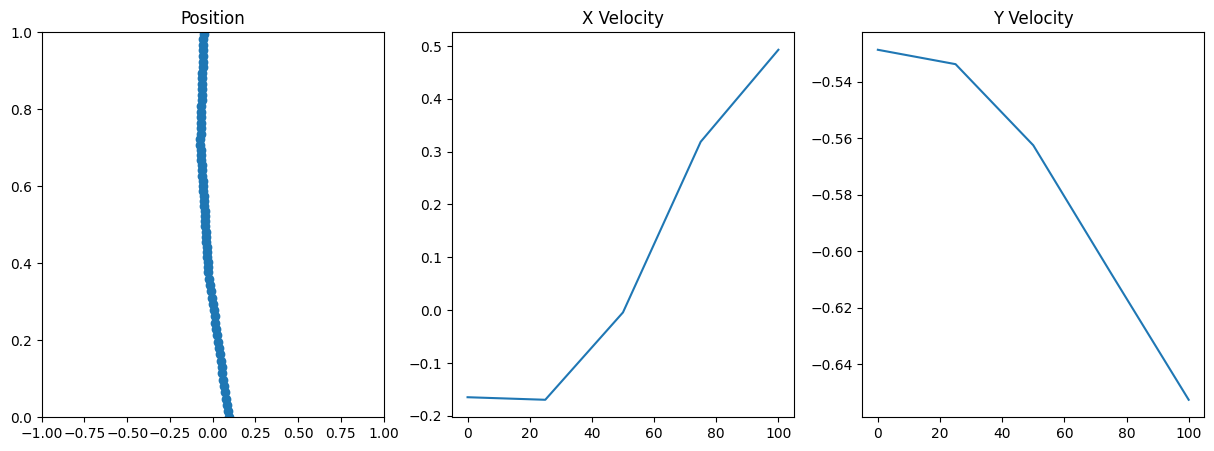

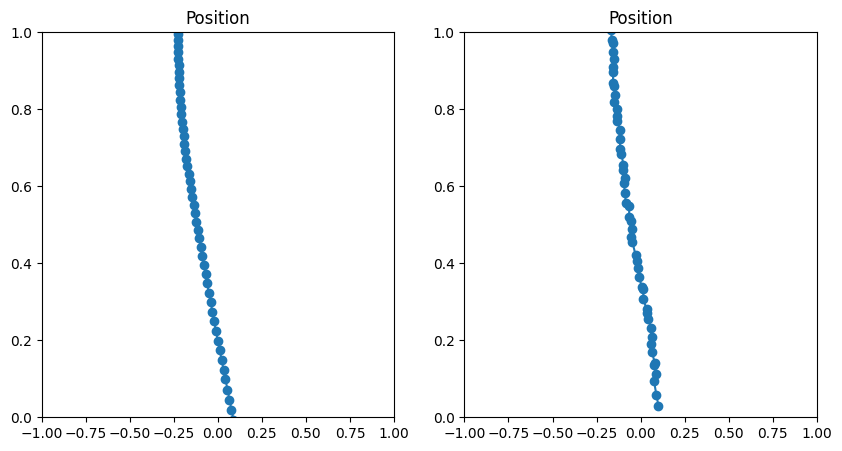

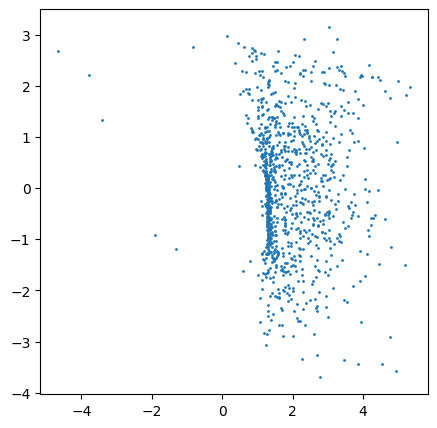

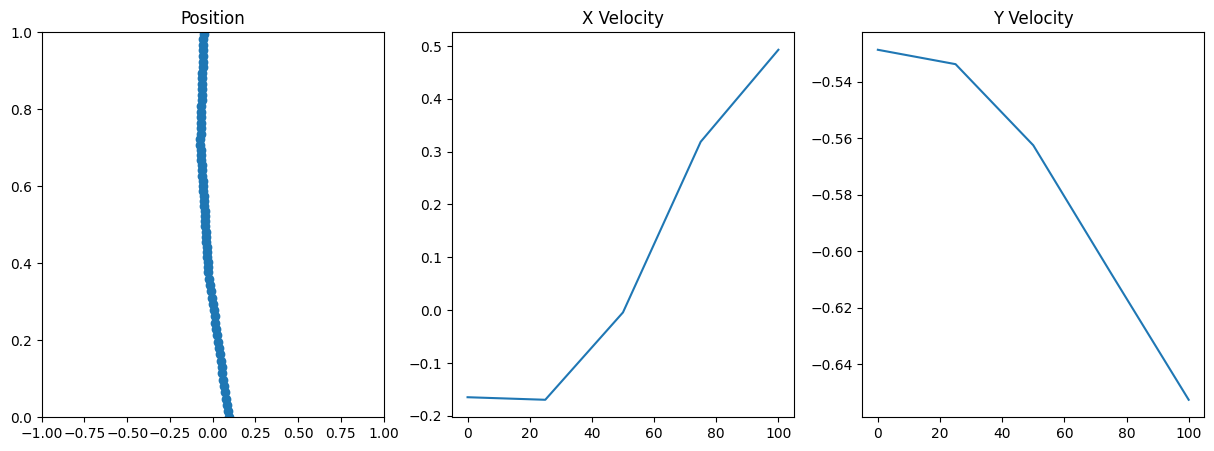

In [18]:
plot_index = 0
x = data.loc[:,(slice(None),'x')].values
y = data.loc[:,(slice(None),'y')].values
vx = data.loc[:,(slice(None),'vx')].values
vy = data.loc[:,(slice(None),'vy')].values

_, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].set_title('Position')
ax[0].set(xlim=[-1, 1], ylim=[0, 1])
ax[0].plot(x[plot_index,:], y[plot_index, :], '-o')
ax[1].set_title('X Velocity')
ax[1].plot(vx[plot_index,:])
ax[2].set_title('Y Velocity')
ax[2].plot(vy[plot_index, :])


# Auto-encoder

In [19]:
encoder = nn.Sequential(nn.Linear(202, 64), 
                        nn.ELU(), 
                        nn.Linear(64, 32), 
                        nn.ELU(), 
                        nn.Linear(32, 4))
decoder = nn.Sequential(nn.Linear(4, 32), 
                        nn.ELU(), 
                        nn.Linear(32, 64),
                        nn.ELU(), 
                        nn.Linear(64, 202))

model = nn.Sequential(encoder, decoder)

In [20]:
X = data.loc[:,(slice(None),['x', 'y'])].values
X = torch.Tensor(X)
print(X.shape)

torch.Size([1017, 202])


In [21]:
dataset = torch.utils.data.TensorDataset(X)
train_loader = torch.utils.data.DataLoader(dataset)

In [22]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Train the model
for epoch in range(30):
    for batch_idx, x in enumerate(train_loader):
        x = x[0]
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion(recon, x)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 0, Loss 0.3665660321712494
Epoch 0, Batch 100, Loss 0.02452944591641426
Epoch 0, Batch 200, Loss 0.027297860011458397
Epoch 0, Batch 300, Loss 0.004398740362375975
Epoch 0, Batch 400, Loss 0.00909196212887764
Epoch 0, Batch 500, Loss 0.004070602357387543
Epoch 0, Batch 600, Loss 0.0009234978351742029
Epoch 0, Batch 700, Loss 0.01107835303992033
Epoch 0, Batch 800, Loss 0.0006970239919610322
Epoch 0, Batch 900, Loss 0.007010658737272024
Epoch 0, Batch 1000, Loss 0.02360749989748001
Epoch 1, Batch 0, Loss 0.009417686611413956
Epoch 1, Batch 100, Loss 0.0008444595732726157
Epoch 1, Batch 200, Loss 0.007570326328277588
Epoch 1, Batch 300, Loss 0.0009637828916311264
Epoch 1, Batch 400, Loss 0.004617361817508936
Epoch 1, Batch 500, Loss 0.0030205172952264547
Epoch 1, Batch 600, Loss 0.000262590212514624
Epoch 1, Batch 700, Loss 0.008436203002929688
Epoch 1, Batch 800, Loss 0.005847100168466568
Epoch 1, Batch 900, Loss 0.0030669947154819965
Epoch 1, Batch 1000, Loss 0.007567474

In [24]:
H = encoder(X).detach()
X_hat = decoder(H).detach()

In [25]:
(X-X_hat).abs().mean()

tensor(0.0298)

In [26]:
X.abs().mean()

tensor(0.5217)

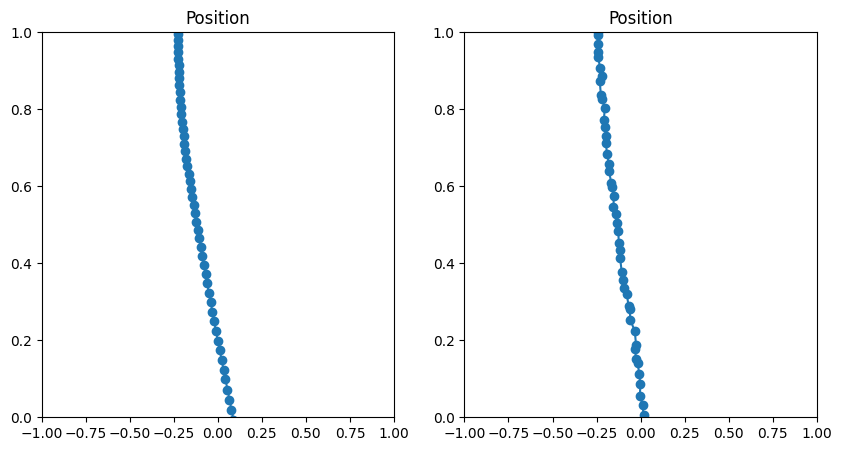

In [27]:
plot_index=4
_,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].set_title('Position')
ax[0].set(xlim=[-1, 1], ylim=[0, 1])
ax[0].plot(X[plot_index, 0:101], X[plot_index, 101:202], '-o')
ax[1].set_title('Position')
ax[1].set(xlim=[-1, 1], ylim=[0, 1])
ax[1].plot(X_hat[plot_index, 0:101], X_hat[plot_index, 101:202], '-o')

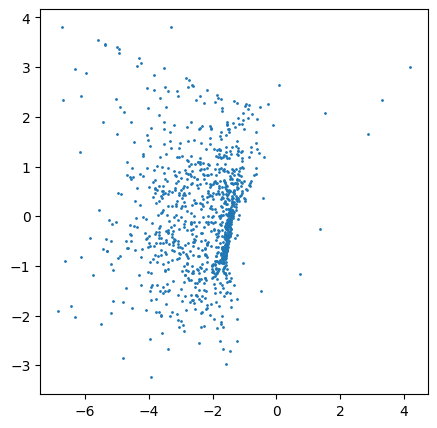

In [28]:
U,E,V = torch.svd(H)
H_2 = (U @ torch.diag(E))[:,0:2].detach().numpy()

_,ax = plt.subplots(1,1,figsize=(5, 5))
ax.scatter(H_2[:,0], H_2[:,1], s=1)